## Reading Datasets
Dataset 1: https://archive.ics.uci.edu/ml/datasets/Mushroom \
Outputs: Edible or poisonous
Adult-all csv: https://raw.githubusercontent.com/jbrownlee/Datasets/master/adult-all.csv

Dataset 2: https://archive.ics.uci.edu/ml/datasets/covertype \
Outputs: 7 integers: different types of cover types for the trees

In [229]:
import pandas as pd
import numpy as np


# Read the data gill-attachmen
Names1 = ['Edibility', 'cap-shape', 'cap-surface', 'cap-color', 'Bruises', 'odor', 'gill-attachment', 'gill-spacing',
        'gill-size', 'gill-color', 'stalk-shape', 'stalk-root', 'stalk-surface-above-ring', 'stalk-surface-below-ring',
        'stalk-color-above-ring', 'stalk-color-below-ring', 'veil-type', 'veil-color', 'ring-number', 'ring-type',
        'spore-print-color', 'population', 'habitat']
data1 = pd.read_csv('mushroom_data/data',  index_col=False, names = Names1)
data1.drop_duplicates(inplace=True)
data1.head()

Names1 = ['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 
          'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', 'Result']
data1 = pd.read_csv('adult-all.csv', header=None,  index_col=False, names = Names1)
data1.drop_duplicates(inplace=True)
data1.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,Result
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [230]:
soil_types = ['Soil_type_' + str(i) for i in range(40)]

wilderness_area = ['wilderness_area_'+str(i) for i in range(4)]

Names2 = ['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology',
         'Horizontal_Distance_To_Roadways', 'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm', 
         'Horizontal_Distance_To_Fire_Points'] + wilderness_area + soil_types+ ['Cover_type']

data2 = pd.read_csv('covertype_forest_data/covtype.data',  names = Names2)
data2.drop_duplicates(inplace=True)
data2.head()

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Soil_type_31,Soil_type_32,Soil_type_33,Soil_type_34,Soil_type_35,Soil_type_36,Soil_type_37,Soil_type_38,Soil_type_39,Cover_type
0,2596,51,3,258,0,510,221,232,148,6279,...,0,0,0,0,0,0,0,0,0,5
1,2590,56,2,212,-6,390,220,235,151,6225,...,0,0,0,0,0,0,0,0,0,5
2,2804,139,9,268,65,3180,234,238,135,6121,...,0,0,0,0,0,0,0,0,0,2
3,2785,155,18,242,118,3090,238,238,122,6211,...,0,0,0,0,0,0,0,0,0,2
4,2595,45,2,153,-1,391,220,234,150,6172,...,0,0,0,0,0,0,0,0,0,5


### Cleaning datasets and replacing missing values

In [231]:
data1.describe()

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week
count,48790.000000,4.879000e+04,48790.000000,48790.000000,48790.000000,48790.000000
mean,38.652798,1.896690e+05,10.078807,1080.217688,87.595573,40.425886
std,13.708493,1.056172e+05,2.570046,7455.905921,403.209129,12.392729
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.175550e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.781385e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.376062e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.490400e+06,16.000000,99999.000000,4356.000000,99.000000


In [233]:
def missing_vals(data1):
    for col in data1.columns:
        if '?' in set(data1[col]):
            print (col)
            print('? values in',col, ":", data1[col].value_counts()['?'])
            data1[col].replace('?', np.nan, inplace=True)
            print('Replacing ? with most frequent:', data1[col].mode().iloc[0])
            data1[col].fillna(data1[col].mode().iloc[0], inplace=True)
            print()
        elif data1[col].isna().any():
            print (col, ": nan values present")
            
missing_vals(data1)
missing_vals(data2)

In [234]:

def convert_cats_labels(data, columns=None, cats_names_dict={}):
    d1c = pd.DataFrame()
    if columns == None:
        for col in data.columns:
            d1c[col] = data[col].astype('category')
            cats_names_dict[col] = dict(enumerate(d1c[col].cat.categories))
            d1c[col] = d1c[col].cat.codes
    
    else:
        for col in data.columns:
            if col in columns:
                d1c[col] = data[col].astype('category')
                cats_names_dict[col] = dict(enumerate(d1c[col].cat.categories))
                d1c[col] = d1c[col].cat.codes
            else:
                d1c[col] = data[col]
                
    return d1c, cats_names_dict


cols_to_cats_d1 = ['workclass', 'education', 'education-num', 'marital-status', 'occupation', 
          'relationship', 'race', 'sex', 'native-country', 'Result']

data1, codes_d1 = convert_cats_labels(data1, columns = cols_to_cats_d1)
# codes_d1:type: {'Edibility': {0: 'EDIBLE', 1: 'POISONOUS'},
# 'cap-shape': {0: 'BELL', 1: 'CONICAL',  2: 'CONVEX',   3: 'FLAT', 4: 'KNOBBED', 5: 'SUNKEN'},

In [237]:
from sklearn.model_selection import train_test_split
X_data1 = data1[data1.columns[data1.columns != 'Result']]
y_data1 = data1.loc[:, 'Result']

X_data2 = data2[data2.columns[data2.columns != 'Cover_type']]
y_data2 = data2.loc[:, 'Cover_type']


X_train1, X_test1, y_train1, y_test1 = train_test_split(X_data1, y_data1, test_size=0.3, random_state=38)
X_train2, X_test2, y_train2, y_test2 = train_test_split(X_data2, y_data2, test_size=0.3, random_state=38)
print("shape for data1 => training:", X_train1.shape, " and testing:", X_test1.shape)
print("shape for data2 => training:", X_train2.shape, " and testing:", X_test2.shape)

shape for data1 => training: (34153, 14)  and testing: (14637, 14)
shape for data2 => training: (406708, 54)  and testing: (174304, 54)


## Decision Trees

In [271]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree  import export_graphviz

try:
    from graphviz import Source
except:
    ! pip3 install graphviz 
    
from IPython.display import SVG

clf = DecisionTreeClassifier(random_state=10)
clf.fit(X_train1, y_train1)
training_score = clf.score(X_train1, y_train1)
testing_score = clf.score(X_test1, y_test1)
print("Dataset: Census pay")
print("Training Accuracy", training_score)
print("Testing Accuracy", testing_score)

target_col = 'Result'
y_train_labels = y_train1.replace(codes_d1[target_col])
# # cross_val_score(clf, iris.data, iris.target, cv=10)

#------------------ showing the image ----------------
# g = Source(export_graphviz(clf, out_file = None, feature_names = X_train1.columns, \
#                             filled = True, rounded = True))
# SVG(g.pipe(format='svg'))





Dataset: Census pay
Training Accuracy 0.9999121599859456
Testing Accuracy 0.8087722894035663


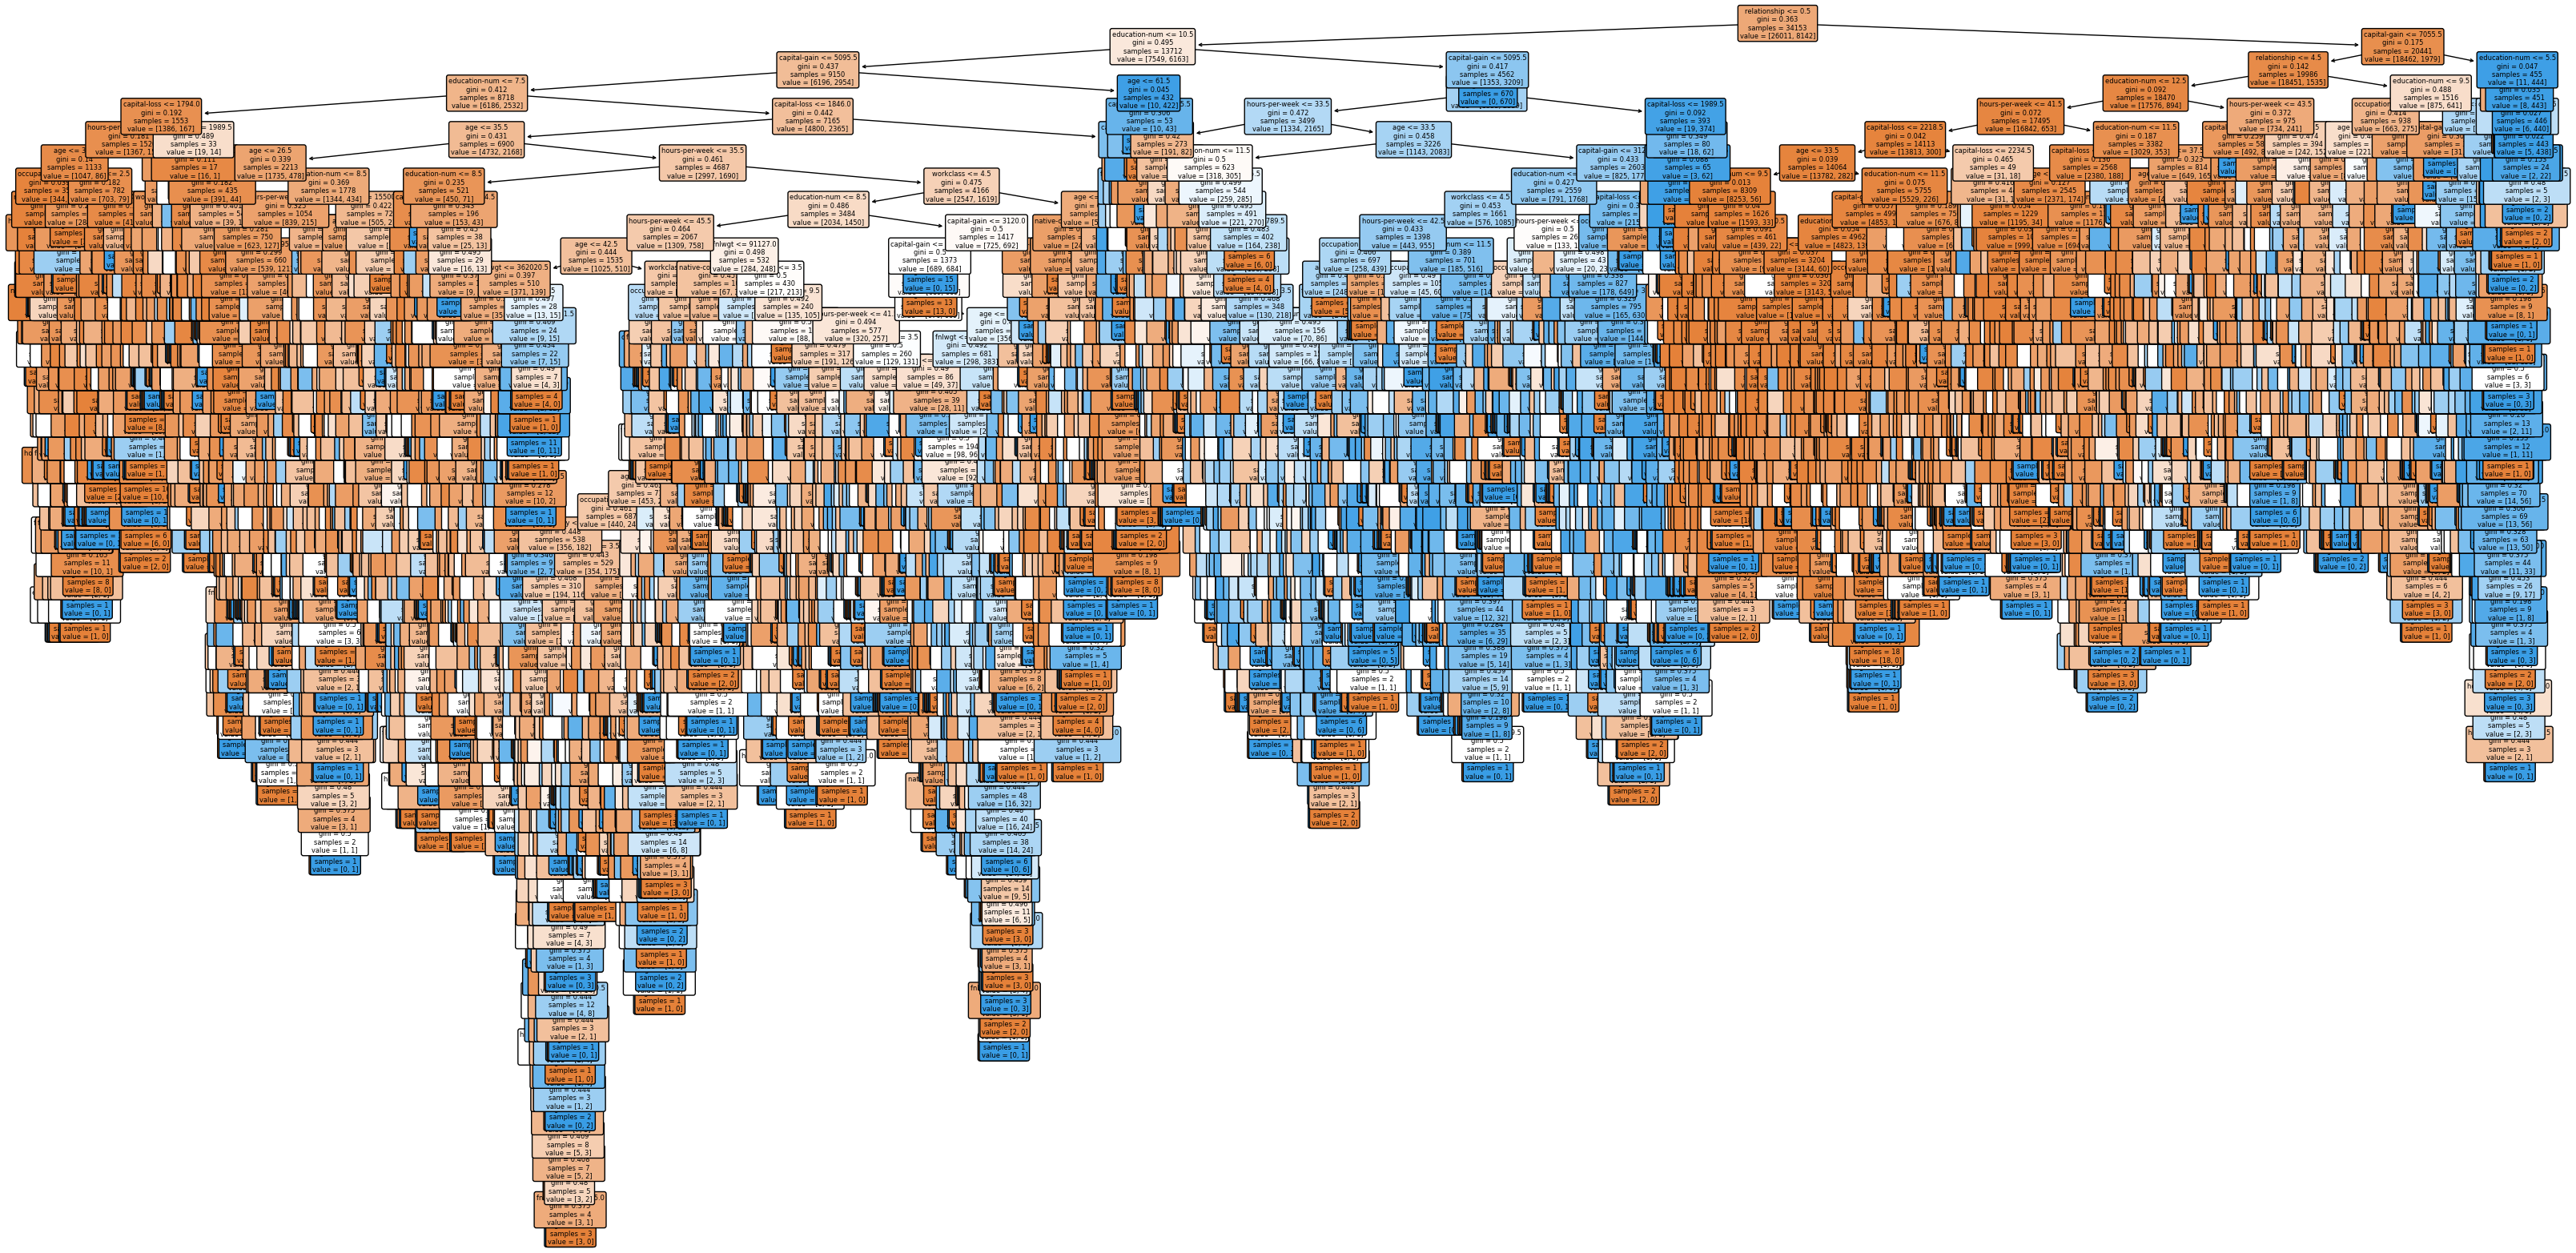

In [262]:
from sklearn import tree
import matplotlib.pyplot as plt
plt.figure(figsize=(40,20))  
_ = tree.plot_tree(clf, feature_names = X_train1.columns, 
             filled=True, fontsize=6, rounded = True)
plt.show()
plt.savefig('DTcensus_unconstrained.png')

In [272]:
import sklearn
sklearn.set_config(print_changed_only=False)

print("Max depth", clf.tree_.max_depth)
print("Number of nodes", clf.tree_.node_count)
clf


Max depth 52
Number of nodes 10155


DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       random_state=10, splitter='best')

### Pruning the trees

In [278]:
#--- early pruning ---- 
from sklearn.model_selection import RandomizedSearchCV

param_dist = {"max_depth": [5, 10, 15, 20],
              "max_features": [1, 5, 8, 10, 13, 'sqrt'],
              "min_samples_leaf": list(range(1, 30)),
              "criterion": ["gini", "entropy"]}

# Instantiate a Decision Tree classifier: tree
tree = DecisionTreeClassifier(random_state = 50)

# Instantiate the RandomizedSearchCV object: tree_cv
tree_cv = RandomizedSearchCV(tree, param_dist,  n_iter=100, cv=5)
tree_cv.fit(X_train1, y_train1)
clf = tree_cv.best_estimator_
print("Best estimator", tree_cv.best_estimator_)

clf.fit(X_train1, y_train1)
training_score = clf.score(X_train1, y_train1)
testing_score = clf.score(X_test1, y_test1)
print("Dataset: Census pay")
print("Training Accuracy", training_score)
print("Testing Accuracy", testing_score)


Best estimator DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=10, max_features=10, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_samples_leaf=10,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       random_state=50, splitter='best')
Dataset: Census pay
Training Accuracy 0.8662782186045149
Testing Accuracy 0.8511990161918426


## KNN classifier

In [210]:
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=3)
neigh.fit(X_train1, y_train1)
neigh.score(X_train1, y_train1)

0.999507631708518

In [211]:
neigh.score(X_test1, y_test1)

0.999015263417036